<a href="https://colab.research.google.com/github/Tako-San/ml-course/blob/main/t1/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [168]:
import sklearn as sk

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import pandas as pd

from sklearn import datasets, linear_model, metrics, preprocessing, model_selection, svm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from scipy.spatial import distance


In [169]:
X_unscaled, y = datasets.load_diabetes(return_X_y=True, as_frame=True, scaled=False)
y = y.to_frame()

X_unscaled_train, X_unscaled_test, y_train, y_test = model_selection.train_test_split(X_unscaled, y, test_size=0.05, random_state=0)

# Анализ датасета

In [170]:
print(f"Размер выборки: {len(X_unscaled)}")
X_unscaled.join(y)

Размер выборки: 442


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,59.0,2.0,32.1,101.00,157.0,93.2,38.0,4.00,4.8598,87.0,151.0
1,48.0,1.0,21.6,87.00,183.0,103.2,70.0,3.00,3.8918,69.0,75.0
2,72.0,2.0,30.5,93.00,156.0,93.6,41.0,4.00,4.6728,85.0,141.0
3,24.0,1.0,25.3,84.00,198.0,131.4,40.0,5.00,4.8903,89.0,206.0
4,50.0,1.0,23.0,101.00,192.0,125.4,52.0,4.00,4.2905,80.0,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,60.0,2.0,28.2,112.00,185.0,113.8,42.0,4.00,4.9836,93.0,178.0
438,47.0,2.0,24.9,75.00,225.0,166.0,42.0,5.00,4.4427,102.0,104.0
439,60.0,2.0,24.9,99.67,162.0,106.6,43.0,3.77,4.1271,95.0,132.0
440,36.0,1.0,30.0,95.00,201.0,125.2,42.0,4.79,5.1299,85.0,220.0


В данной задачи исходное множество описывается 10 входными переменными:

| param | meaning |
|-------|---------|
| age | возраст |
| sex | пол |
| bmi | индекс массы тела |
| bp  | среднее кровяное давление |
| s1 tc | общий холестерин сыворотки |
| s2 ldl | липопротеины низкой плотности |
| s3 hdl | липопротеины высокой плотности |
| s4 tch | общий холестерин / ЛПВП |
| s5 ltg | возможно логарифм уровня триглицеридов в сыворотке |
| s6 glu | уровень сахара в крови |

И одной выходной переменной:

| param | meaning |
|-------|---------|
| target | количественный показатель прогрессирования заболевания через год после исходного уровня |

In [171]:
def printVIF(X):
  print(pd.Series([vif(X.values, i) for i in range(X.shape[1])], index=X.columns))

printVIF(X_unscaled)

age     17.876909
sex     12.192347
bmi     55.155355
bp      69.404363
s1     576.886424
s2     244.913298
s3      52.293365
s4      81.350054
s5     277.183350
s6      93.976986
dtype: float64


In [172]:
# Все признаки имеют vif > 5 => признаки сильно кореллированы. Попробуем отнормировать все признаки

scaler = preprocessing.StandardScaler().fit(X_unscaled_train)

X_train_all = X_unscaled_train
X_test_all = X_unscaled_test
X_all = X_unscaled

X_train_all[X_train_all.columns] = scaler.transform(X_train_all[X_train_all.columns])
X_test_all[X_test_all.columns] = scaler.transform(X_test_all[X_test_all.columns])
X_all[X_all.columns] = scaler.transform(X_all[X_all.columns])

printVIF(X_all)

age     1.217346
sex     1.277930
bmi     1.509496
bp      1.459158
s1     59.266937
s2     39.225073
s3     15.403985
s4      8.891879
s5     10.076466
s6      1.484653
dtype: float64


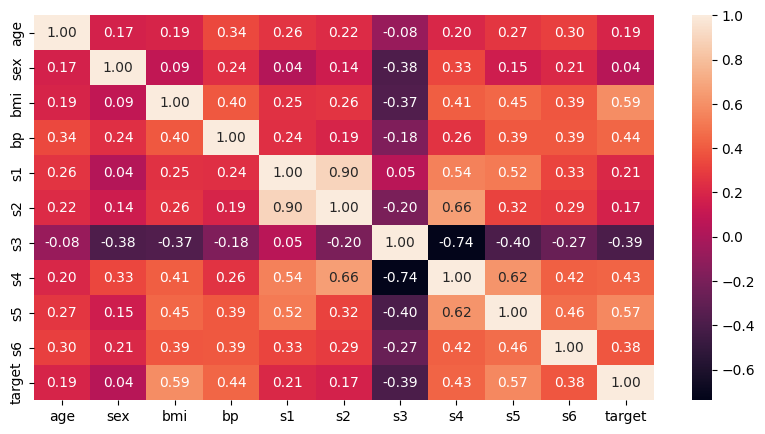

In [173]:
# Значения vif сильно уменьшились, но для некоторых параметров всё еще высоки. Посмотрим взаимную коррелляцию признаков

def print_heatmap(df):
  plt.figure(figsize=(10, 5))
  _ = sns.heatmap(df.corr(), annot=True, fmt='.2f')

print_heatmap(X_all.join(y))

age    1.216932
sex    1.274916
bmi    1.502368
bp     1.457154
s2     2.928747
s3     3.735507
s4     7.818953
s5     2.172950
s6     1.484442
dtype: float64


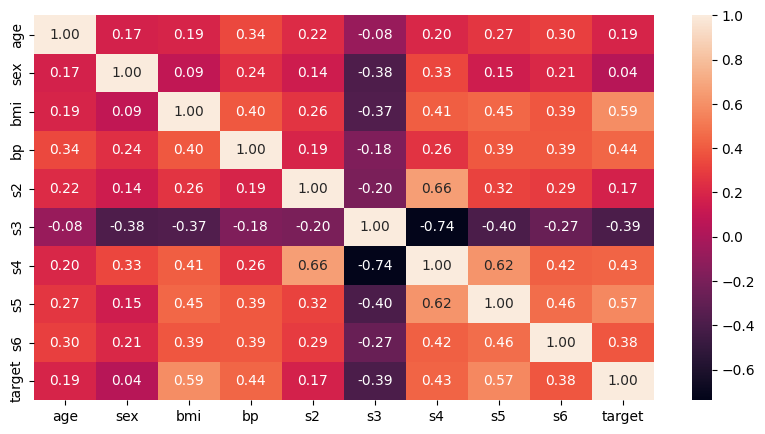

In [174]:
# Видно, что s1 и s2 сильно корреллированы. Попробуем убрать s1

tmp = X_all.drop(["s1"], axis=1)
printVIF(tmp)
print_heatmap(tmp.join(y))

age    1.216325
sex    1.269043
bmi    1.498587
bp     1.447032
s2     1.180844
s3     1.473455
s5     1.640930
s6     1.476926
dtype: float64


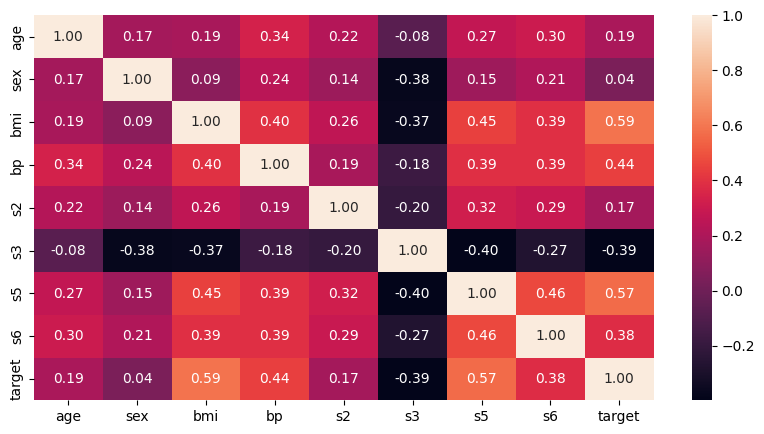

In [175]:
# Уберем s4

tmp = X_all.drop(["s1", "s4"], axis=1)
printVIF(tmp)
print_heatmap(tmp.join(y))

bmi    1.454953
bp     1.334375
s3     1.263107
s5     1.576003
s6     1.412431
dtype: float64


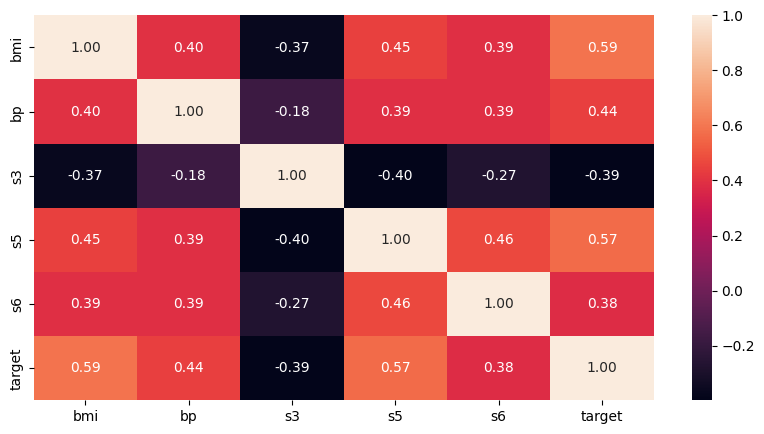

In [176]:
# Теперь все признаки имеют низкий vif и мы можем с ними работать.
# Также уберём признак "s2", "age" и "sex", т.к. они слабо кореллирует с результатом

def drop(pd):
  return pd.drop(["s1", "s4", "sex", "age", "s2"], axis=1)

X = drop(X_all)
X_train = drop(X_train_all)
X_test = drop(X_test_all)

printVIF(X)
print_heatmap(X.join(y))

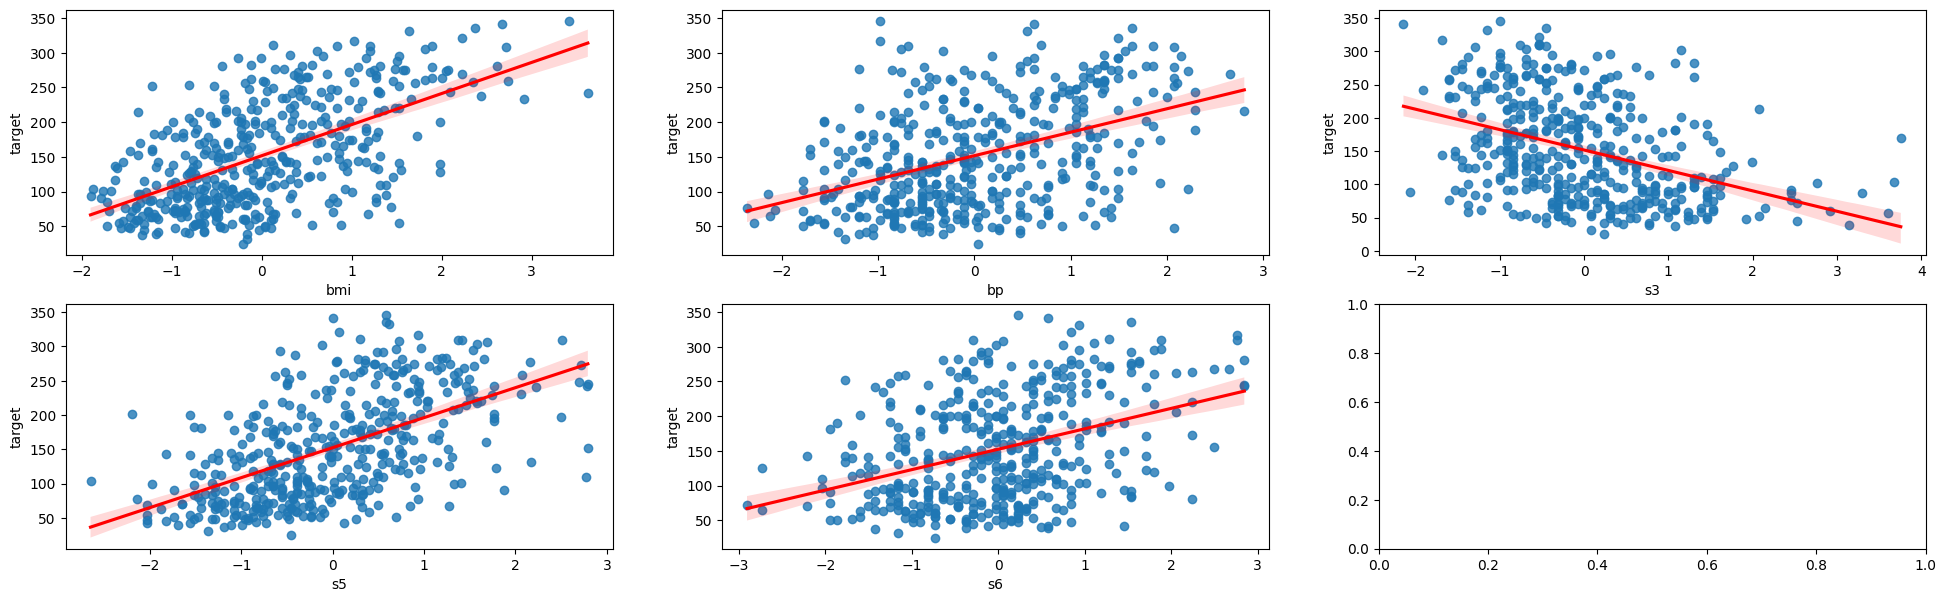

In [177]:
cols = 3
fig, axs = plt.subplots(ncols=cols, nrows=2, figsize=(24, 7))

Xy = X.join(y)
for i, val in enumerate(X.columns.values):
  sns.regplot(x=val, y='target', data=Xy, ax=axs[i // cols][i % cols], fit_reg=True, line_kws={"color": "red"})

# Реализации моделей


In [178]:
# Служебные функции

def print_by_feature(features, target, pred):
  cols = 3
  fig, axs = plt.subplots(ncols=cols, nrows=2, figsize=(24, 7))

  Xy_test = features.join(target);
  for i, val in enumerate(features.columns.values):
    ax = axs[i // cols, i % cols]
    sns.regplot(x=val, y='target', data=Xy_test, ax=ax, fit_reg=True)
    ax.scatter(features[val], pred, color="red")

def print_evaluation_result(ans, pred):
  fig, ax = plt.subplots(figsize=(10,6))
  ax.scatter(ans, pred)
  ax.plot(ax.get_xlim(), ax.get_ylim(), color ='red')
  plt.xlabel('True value')
  plt.ylabel('Predicted values')
  plt.title('Evaluation result')
  plt.show()

def print_result(features, target, pred):
  print("Mean squared error: %.2f" % metrics.mean_squared_error(target, pred))
  print("Coefficient of determination: %.2f" % metrics.r2_score(target, pred)) # 1 is perfect prediction

  print_by_feature(features, target, pred)
  print_evaluation_result(target.values, pred)

## Линейная регрессия

Coefficients: 
 [[25.5464761  13.43248377 -9.55476625 22.12236001  1.702828  ]]
Mean squared error: 3202.55
Coefficient of determination: 0.45


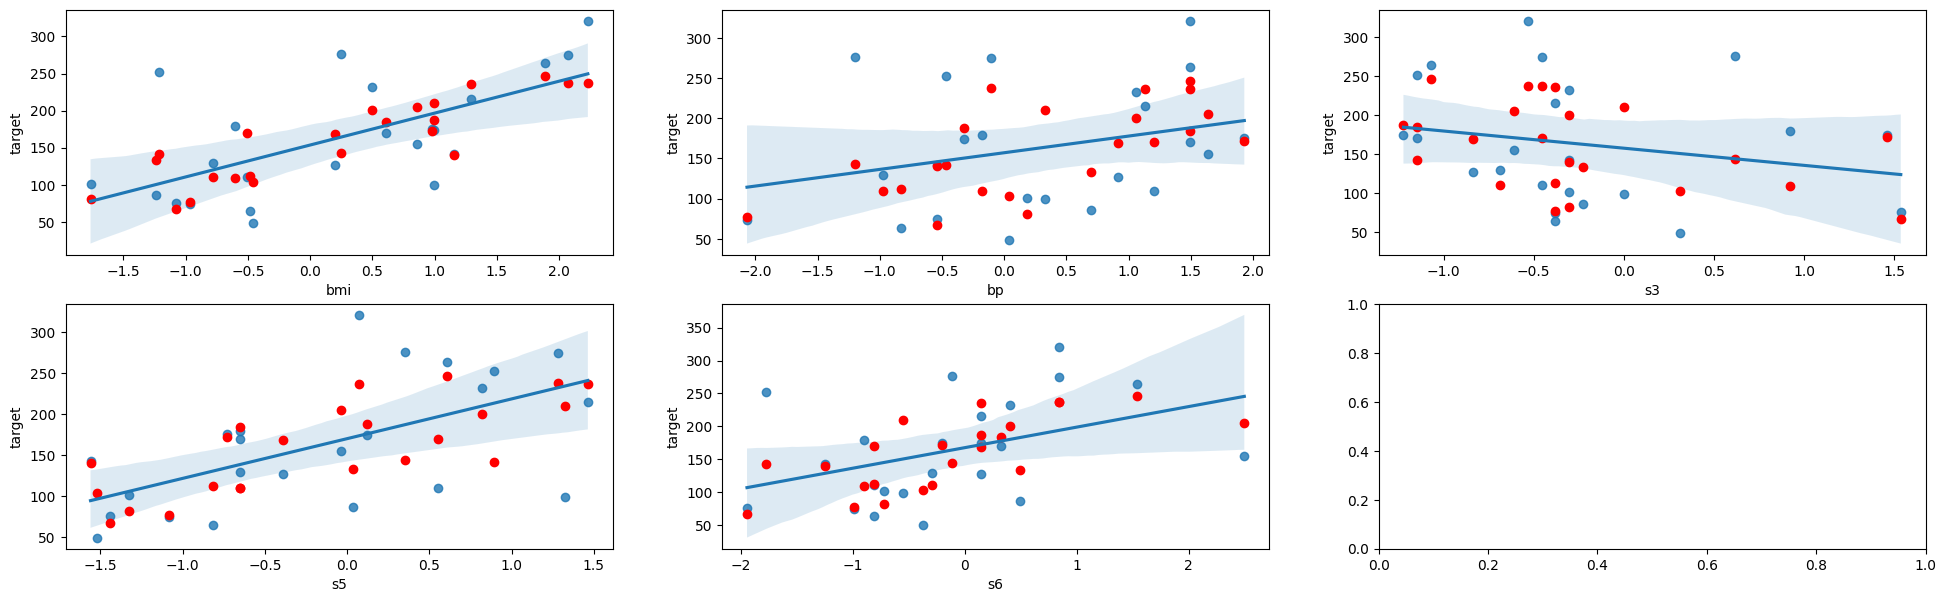

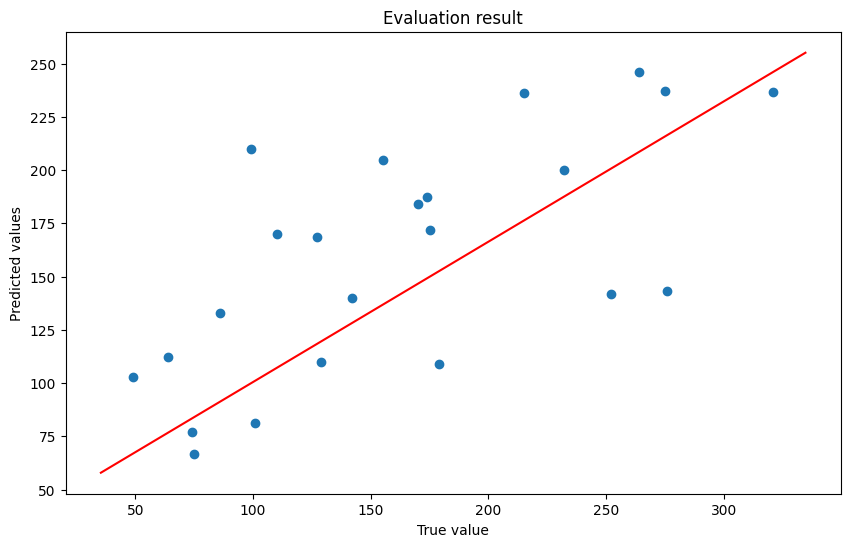

In [179]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
lin_pred = regr.predict(X_test)

print("Coefficients: \n", regr.coef_)
print_result(X_test, y_test, lin_pred)

## Формула Надарая-Ватсона

Mean squared error: 3215.90
Coefficient of determination: 0.45


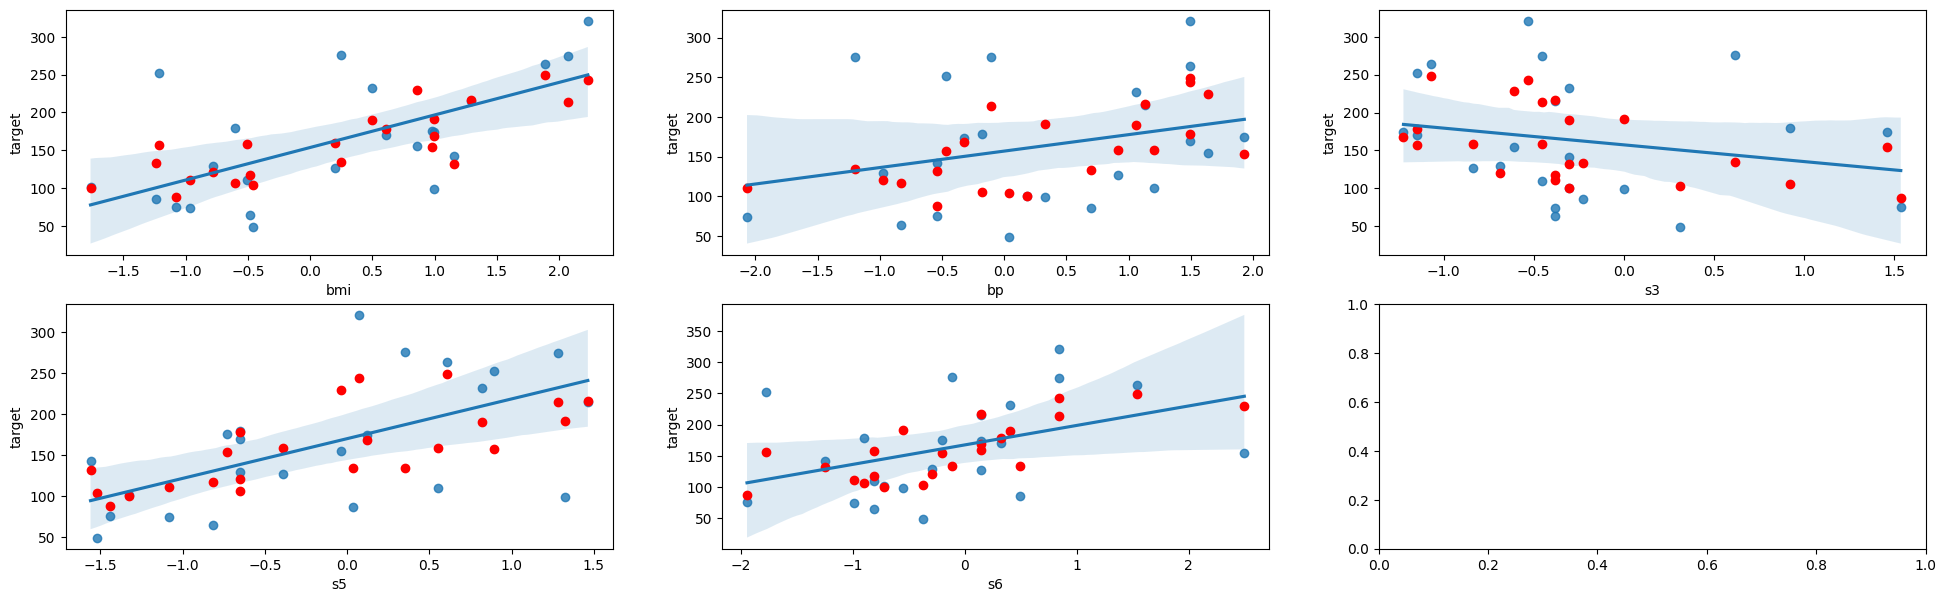

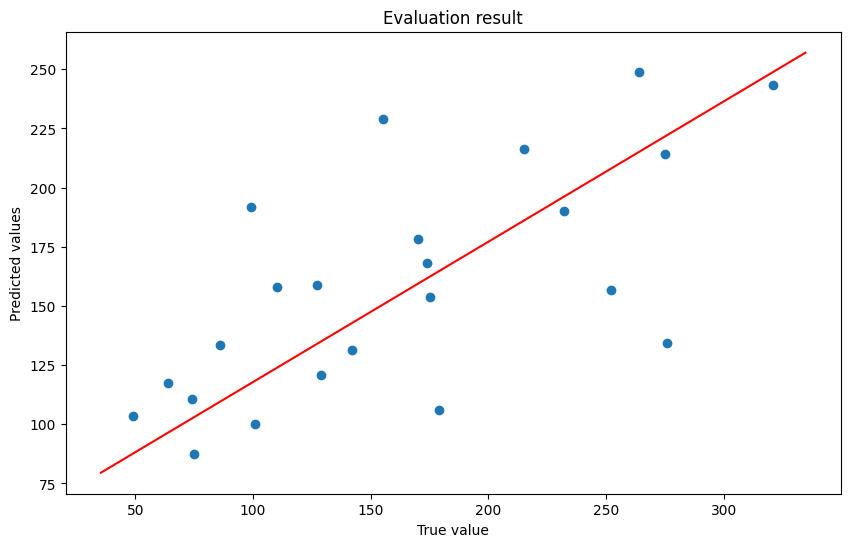

In [180]:
class FNV(object):
    def __init__(self, kernel=None):
        self.X, self.Y = None, None
        self.kernel = lambda x: np.ones_like(x)
        if kernel is not None:
            self.kernel = kernel

    def predict(self, X):
        dst = distance.cdist(X, self.X)
        kernel = self.kernel(dst)

        features = np.sum(self.Y * kernel, axis=-1)
        return features / (np.sum(kernel, axis=-1) + 1e-10)

    def fit(self, X, Y):
        self.X, self.Y = np.array(X), np.array(Y)

def K(dst, h=2):
    ret = np.array(dst)/h
    res = (1 - ret**2) * (np.abs(ret) <= 1)
    return res

fnv = FNV(kernel=lambda x: K(x, h=2.2))
fnv.fit(X_train, y_train.T)
fnv_pred = fnv.predict(np.array(X_test))

print_result(X_test, y_test, fnv_pred)

## SVR

In [181]:
def get_svr_pred(kernel):
  model = svm.SVR(kernel=kernel)
  model.fit(X_train, y_train['target'])
  rbf_pred = model.predict(X_test)
  print_result(X_test, y_test, rbf_pred)

Mean squared error: 4649.81
Coefficient of determination: 0.21


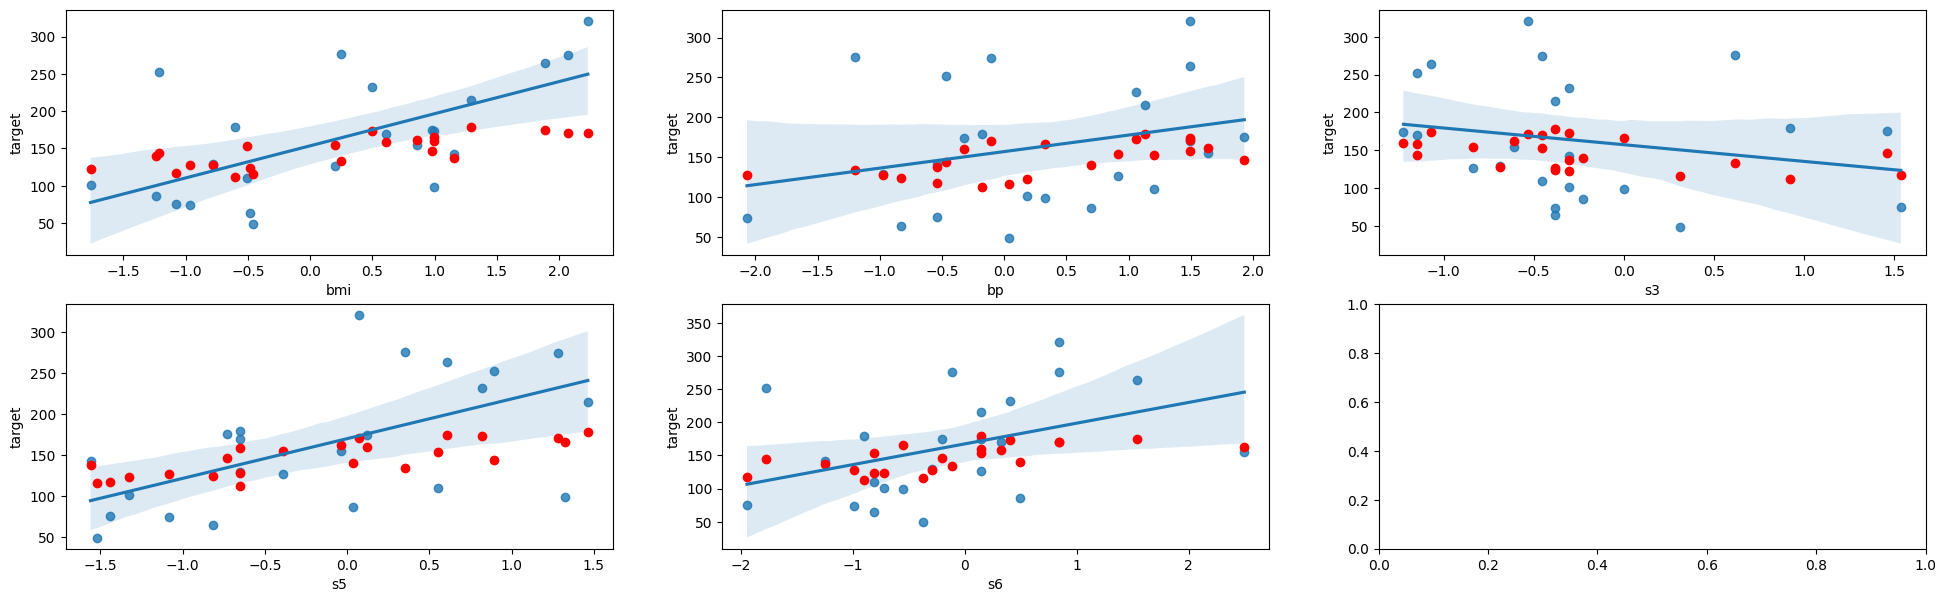

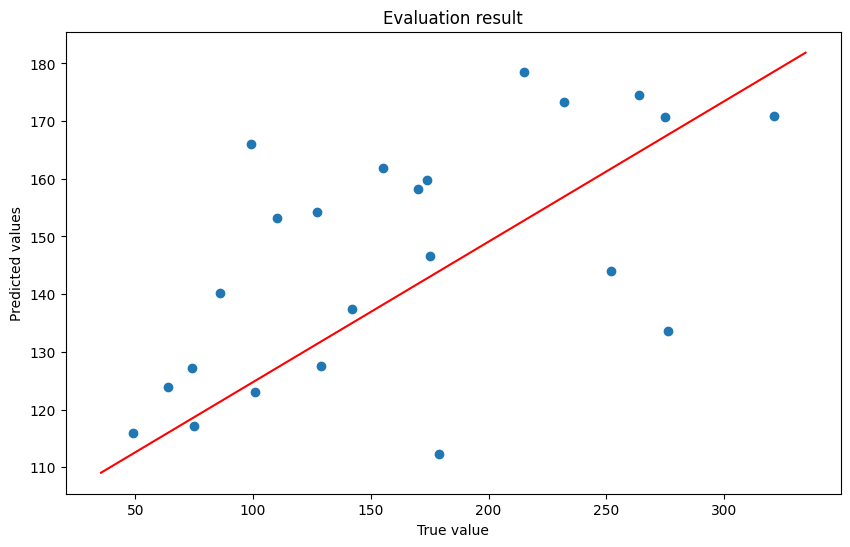

In [182]:
get_svr_pred('rbf')

Mean squared error: 3956.72
Coefficient of determination: 0.32


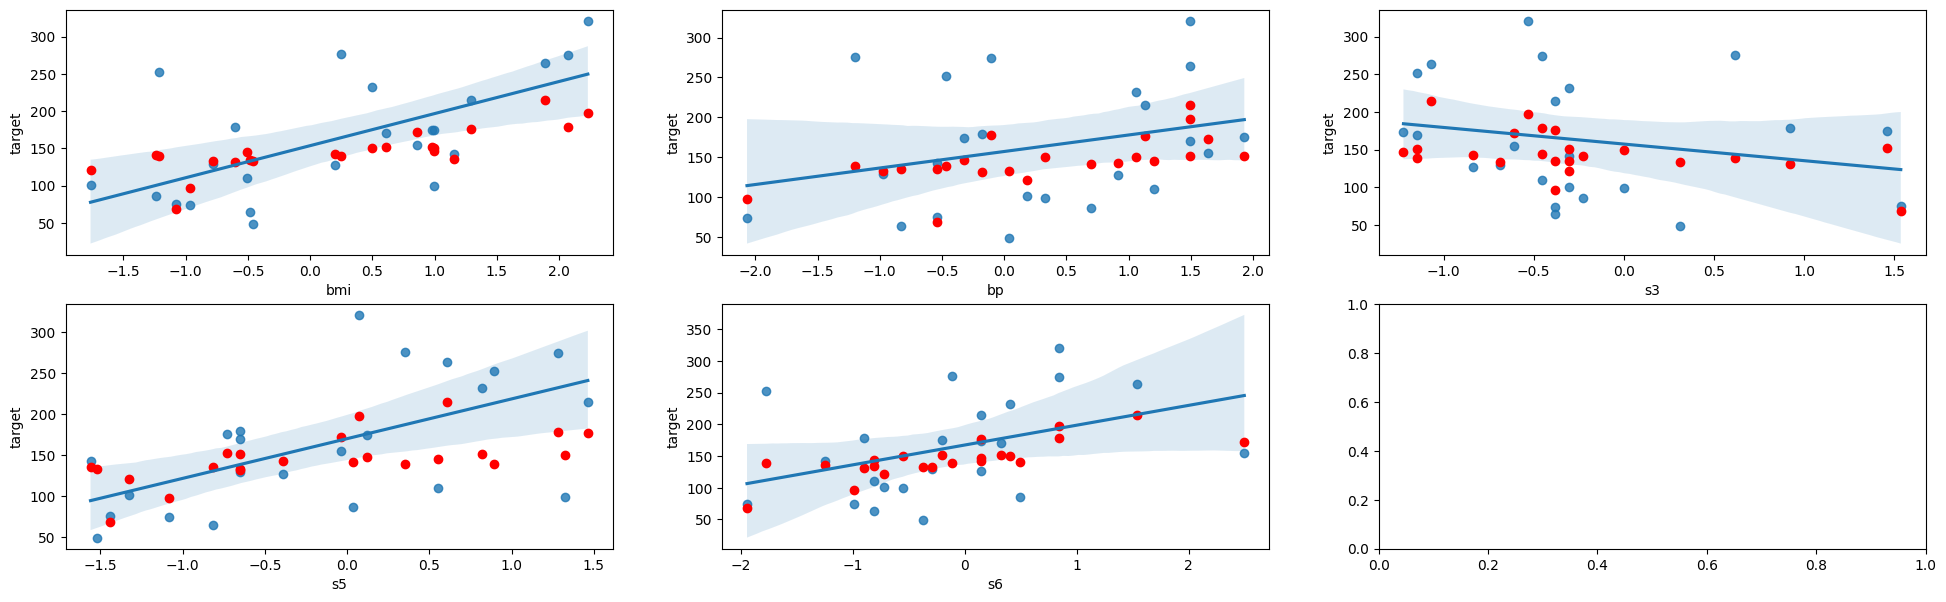

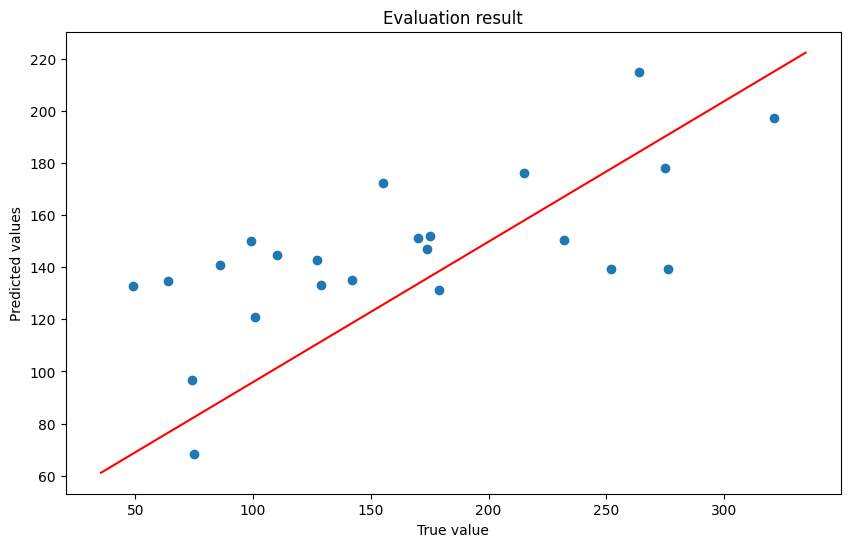

In [183]:
get_svr_pred('poly')

Mean squared error: 3328.55
Coefficient of determination: 0.43


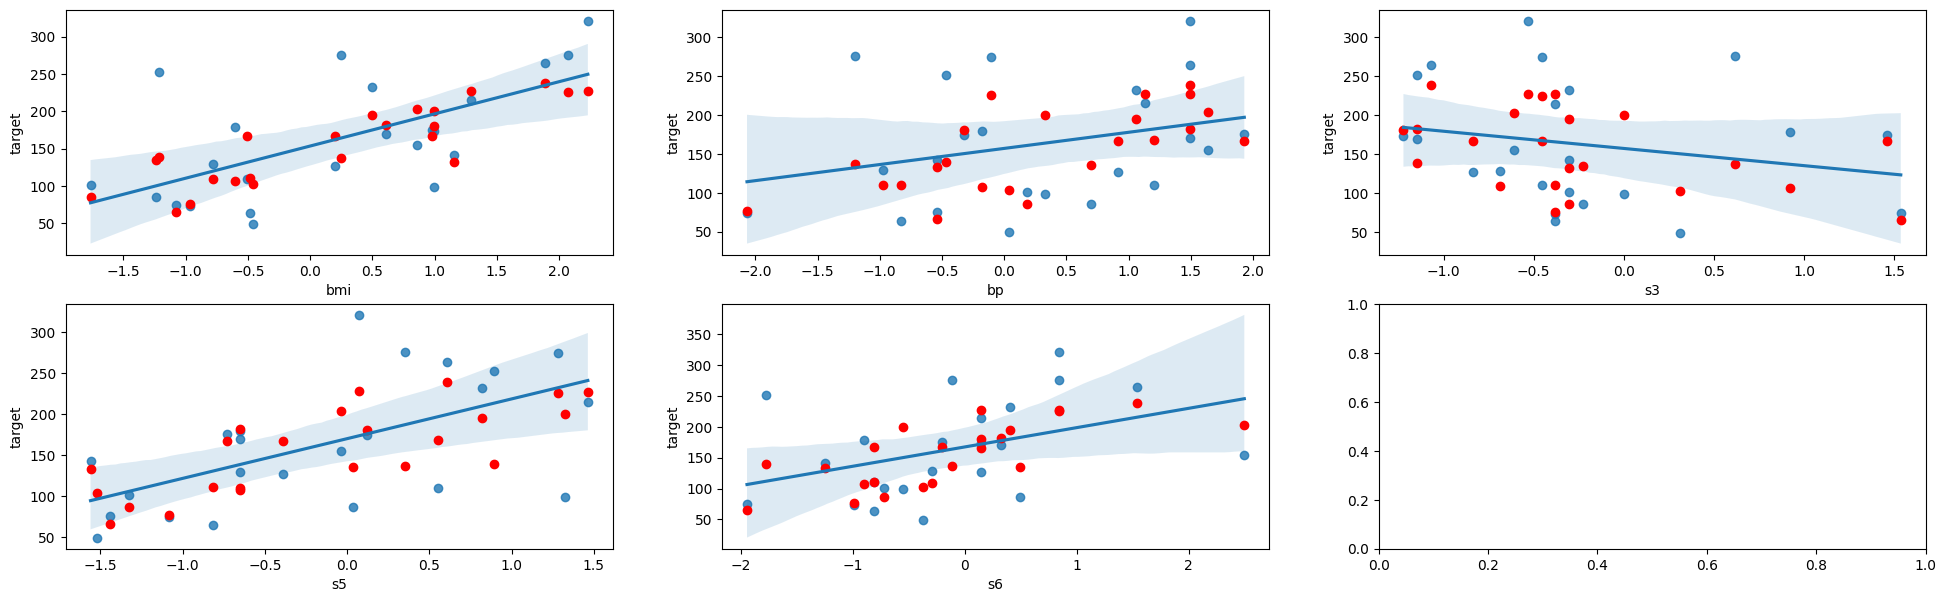

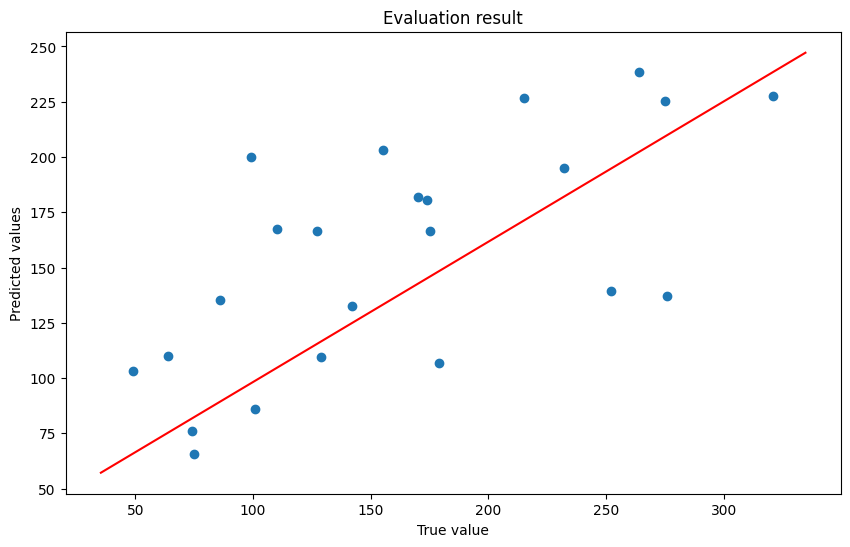

In [184]:
get_svr_pred('linear')

Mean squared error: 3848.04
Coefficient of determination: 0.34


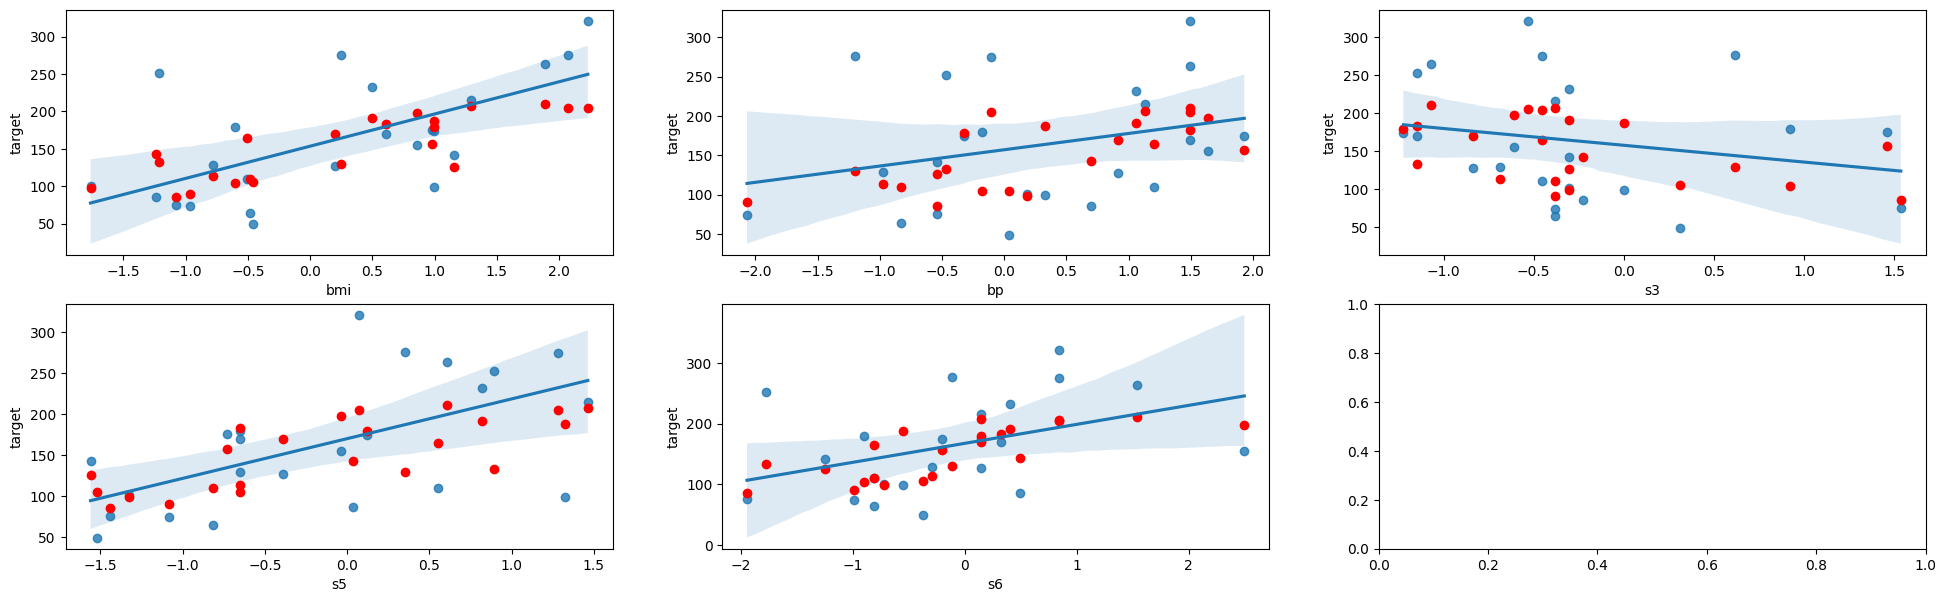

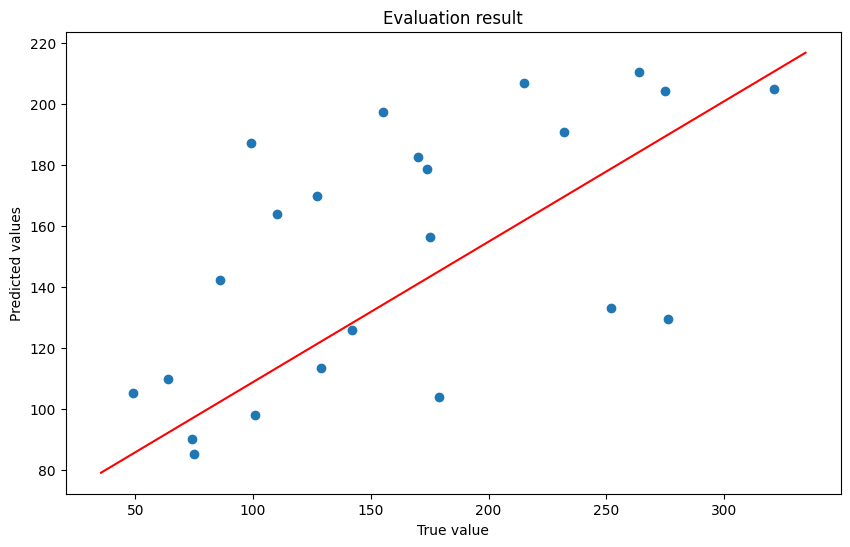

In [185]:
get_svr_pred('sigmoid')